# Predicting Car Prices

In this project, I'll practice the machine learning workflow to predict a car's market price using its attributes. The data set I'll be working with contains information on various cars. For each car I have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.

# Exploring the Data

It's possible to read more about the data set [here](https://archive.ics.uci.edu/ml/datasets/automobile) and can download it directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data). Here's a preview of the data set:

In [31]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Options to set
%matplotlib inline
pd.set_option('display.max_columns', 99)
np.random.seed(1)

# Select columns
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data
cars = pd.read_csv('imports-85.data', names=cols)

cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [32]:
# Select only the columns with continuous values
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

numeric_cars = cars[continuous_values_cols]

numeric_cars.head()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,13495
1,?,88.6,168.8,64.1,48.8,2548,3.47,2.68,9.0,111,5000,21,27,16500
2,?,94.5,171.2,65.5,52.4,2823,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,3.19,3.40,8.0,115,5500,18,22,17450


# Data Cleaning

It's possible to see that the `normalized-losses` column contains missing values represented using `?`. Let's replace these values and look for the presence of missing values in other numeric columns. Let's also rescale the values in the numeric columns so they all range from 0 to 1.

In [33]:
# Replace "?" with NaN
numeric_cars = numeric_cars.replace('?', np.nan)

# Transform all to type float
numeric_cars = numeric_cars.astype('float')

# See how NaN values are in all the columns
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

## Dealing with NaN Values

Because `price` is the column we want to predict, let's remove any rows with missing `price` values.

In [34]:
numeric_cars = numeric_cars.dropna(subset=['price'])

# See how NaN values are in all the columns
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Now, let's replace missing values in other columns using column means.

In [35]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

# See how NaN values are in all the columns
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

## Normalize Values

Let's also normalize all columnns with `StandardScaler()` to have all columns with the same distribution, except the target column.

In [36]:
# Create list of all the columns to normalize
features = numeric_cars.columns.drop('price')

scaler = StandardScaler()

numeric_cars[features] = scaler.fit_transform(numeric_cars[features])

numeric_cars.describe()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,2.010000e+02,201.000000
mean,8.837596e-17,2.209399e-16,-1.414015e-16,7.754991e-16,2.573950e-16,2.982689e-16,4.595550e-16,2.774453e-15,-2.927454e-17,-2.966118e-16,1.148888e-15,2.043694e-17,-2.237017e-16,13207.129353
std,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,1.002497e+00,7947.066342
min,-1.785907e+00,-2.015617e+00,-2.693002e+00,-2.666233e+00,-2.443627e+00,-2.069088e+00,-2.956987e+00,-3.764836e+00,-7.920616e-01,-1.486268e+00,-2.028816e+00,-1.900840e+00,-2.160369e+00,5118.000000
25%,-6.579657e-01,-7.101029e-01,-6.021238e-01,-8.534602e-01,-7.235321e-01,-7.493419e-01,-6.757960e-01,-4.659753e-01,-3.915600e-01,-8.960213e-01,-6.659112e-01,-9.643968e-01,-8.364843e-01,7775.000000
50%,0.000000e+00,-2.969656e-01,-8.143809e-02,-1.855967e-01,1.365155e-01,-2.745434e-01,-7.745078e-02,1.049813e-01,-2.914346e-01,-2.252861e-01,1.907008e-15,-1.840274e-01,-1.009929e-01,10295.000000
75%,4.699755e-01,5.954111e-01,7.565404e-01,3.391531e-01,7.098805e-01,7.176887e-01,9.322568e-01,4.856190e-01,-1.913092e-01,3.381314e-01,8.018329e-01,7.524158e-01,4.874003e-01,16500.000000
max,4.198448e+00,3.652627e+00,2.757926e+00,2.915198e+00,2.470930e+00,2.926955e+00,2.278534e+00,2.896325e+00,3.212954e+00,4.255225e+00,3.108288e+00,3.717819e+00,3.429366e+00,45400.000000


# Regression

Now let's make some prediction firstly using Univariate Models and then with Multivariate Models all based on k-nearest neighbors algorithm.

## Univariate Models

Let's start with some univariate k-nearest neighbors models, one for every column, selecting the best k value with `GridSearchCV()` using a 5-fold cross validation.

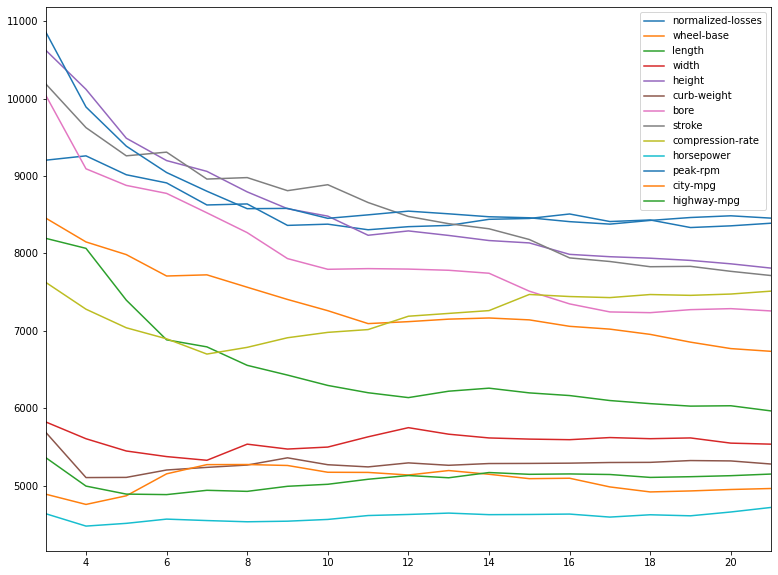

In [37]:
# Set the parameters
parameters = {"n_neighbors": range(3,22)}
target_col = "price"

# Create dataframe to store the results
rmse_results = pd.DataFrame(columns=features, index=range(3,22))

for col in features:
  # Set the regressor 
  knn = KNeighborsRegressor()
  # Set the grid search
  gs = GridSearchCV(knn, parameters, scoring="neg_root_mean_squared_error")
  gs.fit(numeric_cars[[col]], numeric_cars[target_col])
  # Insert the results in the dataframe as positive values
  rmse_results[col] = np.absolute(gs.cv_results_["mean_test_score"])

# Plot the results
rmse_results.plot(figsize=(13,10))

It can be seen that the `horsepower` column give the best results overall.

## Multivariate Models

Finally, let's create some multivariate k-nearest neighbors models, grouping the best columns one by one, selecting the best k value with `GridSearchCV()` using a 5-fold cross validation.

In [38]:
# Compute average RMSE across different k values for each column
sorted_series_avg_rmse = rmse_results.mean().sort_values()
print(sorted_series_avg_rmse)

# Take the index
sorted_features = sorted_series_avg_rmse.index

horsepower           4598.423495
city-mpg             5065.203105
highway-mpg          5075.897784
curb-weight          5285.697315
width                5572.638306
length               6525.307290
compression-rate     7219.726013
wheel-base           7332.676828
bore                 7979.096349
normalized-losses    8565.426625
height               8572.728320
stroke               8580.450071
peak-rpm             8774.618978
dtype: float64


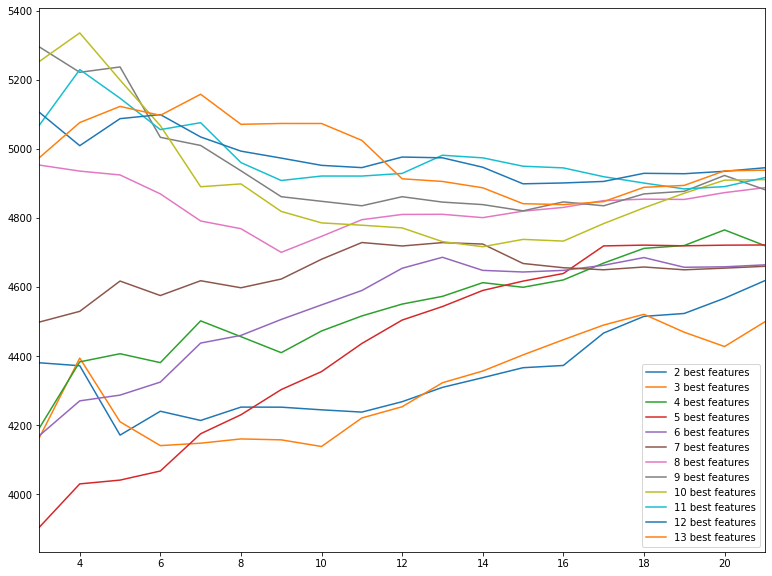

In [39]:
# Set the parameters
parameters = {"n_neighbors": range(3,22)}
target_col = "price"
group_features = [sorted_features[0]]

# Create dataframe to store the results
rmse_results_groups = pd.DataFrame(columns=[str(x) + " best features" for x in range(2, len(sorted_features)+1)], index=range(3,22))

for idx, col in enumerate(sorted_features[1:]):
  # Append the column to the list
  group_features.append(col)
  # Set the regressor 
  knn = KNeighborsRegressor()
  # Set the grid search
  gs = GridSearchCV(knn, parameters, scoring="neg_root_mean_squared_error")
  gs.fit(numeric_cars[group_features], numeric_cars[target_col])
  # Insert the results in the dataframe as positive values
  rmse_results_groups.iloc[:,idx] = np.absolute(gs.cv_results_["mean_test_score"])

# Plot the results
rmse_results_groups.plot(figsize=(13,10))

It can be seen that it's better to choose a k value between 3 and 6.

In [40]:
# Compute average RMSE across different k values for each group
rmse_results_groups.mean().sort_values()

3 best features     4312.344477
2 best features     4353.687004
5 best features     4423.676643
6 best features     4537.502832
4 best features     4540.679330
7 best features     4644.600962
8 best features     4836.085117
10 best features    4896.466295
9 best features     4941.488242
12 best features    4976.386773
13 best features    4977.527854
11 best features    4978.401573
dtype: float64

Groups with 2, 3 or 5 best features performs better than groups with more features.

# Conclusion

Interestingly enough, the RMSE value actually *increased* when all of the features available are used. This means that selecting the right features is important and that using more features doesn't automatically improve prediction accuracy.